# Battle-of-Neighborhoods-New-York-City

# 1. Introduction

### 1.1 Background

New York City is the most populous city in the United States and is seen as the financial, media and cultural capital of the world. It is also a significant location for international diplomacy as it is home to the United Nations headquarters. The city has five boroughs and is linguistically very diverse. It has more than 3.2 million residents that are foreign-born, making it the largest city in the world with foreign-born population as of 2016. All the boroughs are culturally diverse. However, Africans in New York City for example, mostly live in the Bronx, Queens and Brooklyn, with few found in Manhattan and Staten Island. Due to the city’s characteristics and location, it is a huge tourist hub as people all over the world visit the city annually in large numbers.

### 1.2 Problem

New York City’s diversity and characteristics comes with high demand for different cuisines. Restaurants are big part of the city’s uniqueness as different delicacies can be found in the city. The essence of this project is to find out African restaurants in the five boroughs of the city. This will help Africans and individuals interested in African foods to know the areas with good African restaurants based average ratings. It will also enable individuals interested in setting up African restaurants to know viable boroughs for such business in the city.

# 2. Data Sources and Approach

This project will focus on African restaurants in New York City and the borough with the best African restaurants. It will also help people interested in opening African restaurants to make informed decision based on availability of restaurants in the boroughs. The following data sources and approach will be used.

### 2.1	New York City Neighborhood Data

This data contains the five boroughs in the city and their neighborhoods. It will give us a better understanding of the city’s neighborhoods

Data source: https://cocl.us/new_york_dataset

### 2.2	Foursquare API

This data will be used to get all the venues in the neighborhoods and retrieve African restaurants in these venues for further analysis in addressing the research problems

Data source: Foursquare

### 2.3	Approach

* Retrieve New York City data from https://cocl.us/new_york_dataset
* Retrieve all venues in the neighborhoods from Foursquare
* Filter the venues from Foursquare to retrieve venues that have African restaurants
* Get information on ratings, likes and tips count for each identified African restaurant using Foursquare API
* Get information on the borough with best average rating for African restaurants using Foursquare API
* Visualize findings using matplotlib and folium


# 3. Methodology

### 3.1 Exploratory Data Analysis

In [1]:
# Import relevant libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import os
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [3]:
# Define a function to create a data set about New York City

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [4]:
new_york_data=get_new_york_data()

In [5]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
new_york_data.shape

(306, 4)

###### From the above information, there are 306 neighborhoods in New York City

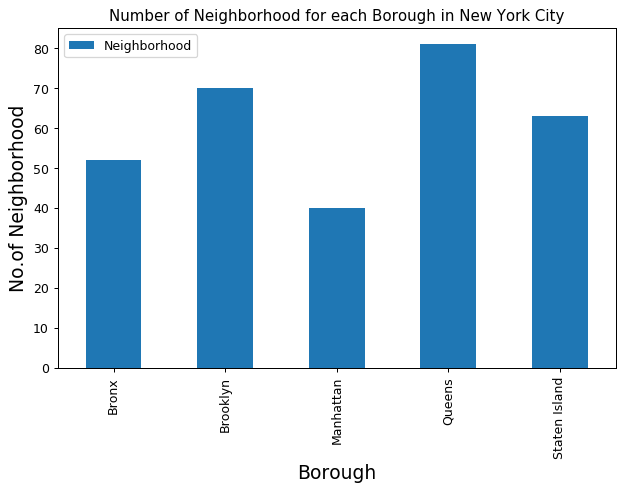

In [9]:
# Plotting a bar chart to show New York City boroughs and the number of neighborhoods

plt.figure(figsize=(8,5), dpi = 90)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### From the above chart, it shows Queens has the highest number of neighborhoods in the city

In [10]:
# Define function for getting lattitude and longitude of location

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [11]:
# Define function to get venue details using Foursquare API

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0B0BYPAYBX4WZLGK1GGUXIAWXJO15GDZ5CVPLNQX01FBHNRV' # your Foursquare ID
    CLIENT_SECRET = 'ABRCNGUGM0EY41BTSTJHMCDESUDWER2NTFTG2AMYC3PFIBAC' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0B0BYPAYBX4WZLGK1GGUXIAWXJO15GDZ5CVPLNQX01FBHNRV' # your Foursquare ID
    CLIENT_SECRET = 'ABRCNGUGM0EY41BTSTJHMCDESUDWER2NTFTG2AMYC3PFIBAC' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Retrieve African retaurants in the city

In [18]:
# prepare neighborhood list that contains african resturants

column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Resturants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) African Resturants in Wakefield, Bronx:0
( 2 / 306 ) African Resturants in Co-op City, Bronx:0
( 3 / 306 ) African Resturants in Eastchester, Bronx:0
( 4 / 306 ) African Resturants in Fieldston, Bronx:0
( 5 / 306 ) African Resturants in Riverdale, Bronx:0
( 6 / 306 ) African Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) African Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) African Resturants in Woodlawn, Bronx:0
( 9 / 306 ) African Resturants in Norwood, Bronx:0
( 10 / 306 ) African Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) African Resturants in Baychester, Bronx:0
( 12 / 306 ) African Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) African Resturants in City Island, Bronx:0
( 14 / 306 ) African Resturants in Bedford Park, Bronx:0
( 15 / 306 ) African Resturants in University Heights, Bronx:2
( 16 / 306 ) African Resturants in Morris Heights, Bronx:0
( 17 / 306 ) African Resturants in Fordham, Bronx:1
( 18 / 306 ) African Resturants in East Tremont, Bronx:

#### Analyze above dataset of African restaurants

In [19]:
african_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix


In [20]:
african_rest_ny.shape

(13, 4)

#### From above analysis, there are 13 African restaurants in New York City

#### Plot a bar chart showing the distribution of African restaurants across the boroughs of the city

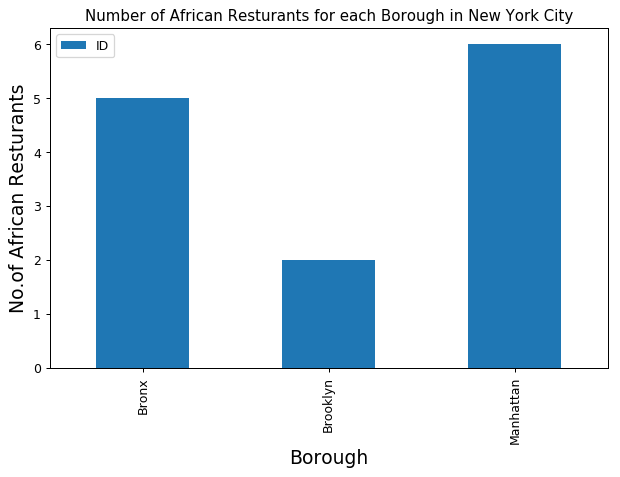

In [21]:
plt.figure(figsize=(8,5), dpi = 90)
# title
plt.title('Number of African Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

* From the above bar chart, Manhattan has the highest number of African restaurants in the city
* Queens and Staten Island do not have any African restaurant

#### Bar Chart showing African restaurants in neighborhoods of the city

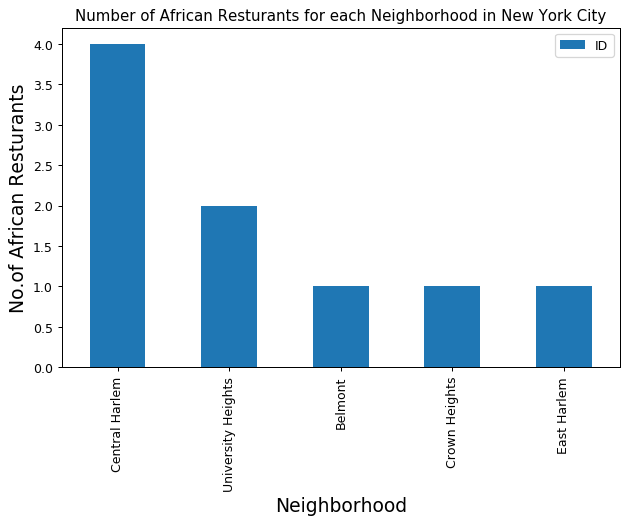

In [23]:
plt.figure(figsize=(8,5), dpi = 90)
# title
plt.title('Number of African Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

* Central Harlem in Manhattan has the highest number of African restaurants in the city

In [24]:
# Count of African restaurants in Central Harlem

african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

,Borough,Neighborhood,ID,Name
6,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
7,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
8,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant
9,Manhattan,Central Harlem,5004a9e5e4b034c2950659fd,Les Ambassades Senegalais Bistro


* Out of the 13 African restaurants in New York City, 4 are in Central Harlem

#### Explore ranking of each of the 13 restaurants

In [25]:
# prepare neighborhood list that contains african resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID             Name  Likes  Rating  Tips
0  4c2f8b1b7cc0c9b6a1eaeb9a  Accra Resturant      9     7.3     3
( 1 / 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 2 / 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 3 / 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 4 / 13 ) processed
                         ID          Name  Likes  Rating  Tips
0  51d4d2cc454a777ed5a76c57  Cafe Rue Dix    201     8.4    59
( 5 / 13 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53e01975498e78c0915599bf  Ponty Bistro Harlem    105     8.6    30
( 6 / 13 ) processed
                         ID                 Name  Likes  Rating  Tip

In [26]:
african_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,7.3,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,201,8.4,59


In [27]:
african_rest_stats_ny.shape

(13, 7)

In [28]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
Borough         13 non-null object
Neighborhood    13 non-null object
ID              13 non-null object
Name            13 non-null object
Likes           13 non-null object
Rating          13 non-null float64
Tips            13 non-null object
dtypes: float64(1), object(6)
memory usage: 808.0+ bytes


#### The data types for 'Likes', 'Rating' and 'Tips' are not uniform. We will convert data types of 'Likes' and 'Tips' which are strings to floats for more analysis

In [29]:
african_rest_stats_ny['Likes']=african_rest_stats_ny['Likes'].astype('float64')

In [30]:
african_rest_stats_ny['Tips']=african_rest_stats_ny['Tips'].astype('float64')

In [31]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
Borough         13 non-null object
Neighborhood    13 non-null object
ID              13 non-null object
Name            13 non-null object
Likes           13 non-null float64
Rating          13 non-null float64
Tips            13 non-null float64
dtypes: float64(3), object(4)
memory usage: 808.0+ bytes


In [33]:
# Resturant with maximum Likes

african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                201
Rating                               8.4
Tips                                  59
Name: 4, dtype: object

* Cafe Rue Dix in Crown Heights, Brooklyn has the highest likes for African restaurants

In [34]:
# Resturant with maximum Rating

african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood            Hamilton Heights
ID              53e01975498e78c0915599bf
Name                 Ponty Bistro Harlem
Likes                                105
Rating                               8.6
Tips                                  30
Name: 5, dtype: object

* Ponty Bistro Harlem in Hamilton Heights, Manhattan has the highest African restaurant rating

In [35]:
# Resturant with maximum Tips

african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                201
Rating                               8.4
Tips                                  59
Name: 4, dtype: object

* Cafe Rue Dix in Crown Heights, Brooklyn has the highest tips for African restaurants

#### Average rating per neighborhood

In [36]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [38]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(9)

,Neighborhood,Average Rating
3,East Harlem,8.60
5,Hamilton Heights,8.60
2,Crown Heights,8.40
1,Central Harlem,7.75
0,Belmont,7.50
4,Fordham,7.50
8,University Heights,7.40
7,Mount Hope,7.30
6,Highland Park,6.00


* East Harlem and Hamilton Heights neighborhoods both in Manhattan have the highest average rating for African restaurants

#### Average rating per borough

In [39]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [40]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.033333
0,Bronx,7.420000
1,Brooklyn,7.200000


* Manhattan has the highest average rating for African restaurants

#### Bar Chart showing average rating per borough

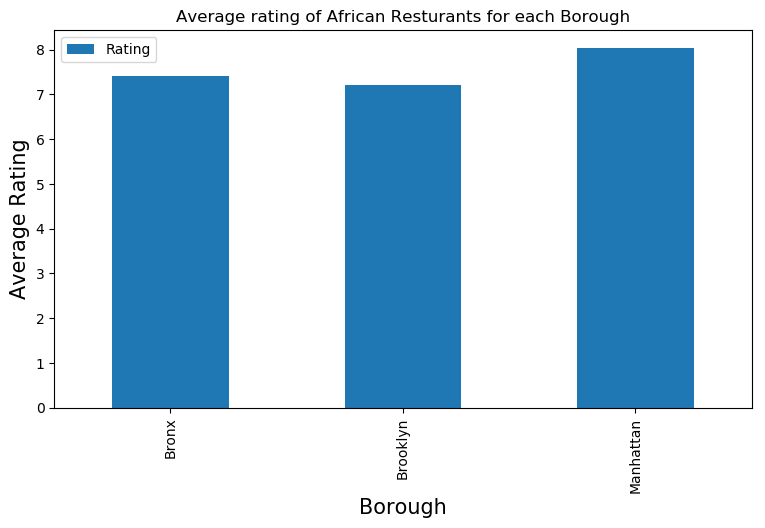

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of African Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Neighborhoods with average rating of 7 and above

In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [43]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Belmont,7.50
1,Central Harlem,7.75
2,Crown Heights,8.40
3,East Harlem,8.60
4,Fordham,7.50
5,Hamilton Heights,8.60
7,Mount Hope,7.30
8,University Heights,7.40


#### Merging stats for better understanding

In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [46]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Belmont,40.857277,-73.888452,7.50
1,Manhattan,Central Harlem,40.815976,-73.943211,7.75
2,Brooklyn,Crown Heights,40.670829,-73.943291,8.40
3,Manhattan,East Harlem,40.792249,-73.944182,8.60
4,Bronx,Fordham,40.860997,-73.896427,7.50
5,Manhattan,Hamilton Heights,40.823604,-73.949688,8.60
6,Bronx,Mount Hope,40.848842,-73.908299,7.30
7,Bronx,University Heights,40.855727,-73.910416,7.40


#### Visualize the average rating in a map

In [47]:
# create map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)

In [48]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='yellow',
            fill=True,
            fill_color='purple',
            fill_opacity=0.6
        )
    )

In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [50]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# 4. Results

From the exploratory analysis, there are 13 African restuarnats in New York City, with 6 of those in Manhattan, 5 in Bronx and 2 in Brooklyn. Queens and Staten Island do not have a single African restaurant.
Central Harlem in Manhattan is the neighborhood in the city with the highest number of African Restaurants as it is home to 4 restaurants.
Cafe Rue Dix in Crown Heights, Brooklyn has the highest likes for African restaurants, while Ponty Bistro Harlem in Hamilton Heights, Manhattan has the highest African restaurant rating. Cafe Rue Dix in Crown Heights, Brooklyn also has the highest tips for African restaurants.
In terms of average rating per neighborhood, East Harlem and Hamilton Heights neighborhoods both in Manhattan have the highest average rating for African restaurants with a rating of 8.60 each. Manhattan has the highest average rating for African restaurants per borough while Brooklyn has the least average rating. As shown in the analysis and map, 8 of the neighborhoods have at least an average restaurant rating of 7.0

# 5. Discussion

Despite the large presence of Africans in Queens as reported by Council on Foreign Relations, it is surprising to know that there is not single African restaurant in Queens and also in Staten Island. It is understandable that Mahattan, which is the major tourist hub in the city, and The Bronx, which has the highest number of Africans in the city, have the first and second highest numbers of African restaurants in the city respectively. Manhattan being a tourist hub could also explain the reason why the restaurants there have better rating as owners would want to make their meals taste good for patronage. I would recommend for prospective African restaurant owners to consider opening some in Queens since the borough has relatively large presence of Africans.

# 6. Conclusion

This project has revealed some interesting information about African restaurants in New York City. An individual that wants to have a good taste of African cuisine should consider going to Manhattan as their foods have better rating. For those considering starting such business of owning an African retaurant in New York City, Queens might be a good location to have one as there is currently no single African restaurant there. 

### New York City and African Population Information Sources

https://en.wikipedia.org/wiki/New_York_City

https://www.cfr.org/blog/where-african-immigrants-live-new-york-city